In [ ]:
import pandas as pd
import scanpy as sc
import anndata as ad

# --- load files ---
meta = pd.read_csv("Data/synthetic_data/synthetic_coordinates.csv", index_col=0)  # cells × genes
expr = pd.read_csv("Data/synthetic_data/synthetic_counts.csv", index_col=0)     # cell metadata
print(" expr.shape[0] : ",expr.shape)

# sometimes expr has genes as rows → transpose if needed

expr = expr.T
print(" expr.shape[0] : ",expr.shape)

# --- build AnnData ---
adata = ad.AnnData(X=expr.values)
adata.obs = meta.loc[expr.index]          # match cells      # match genes
adata.obs_names = expr.index.astype(str)
adata.var_names = expr.columns.astype(str)

adata.obsm["spatial"] = meta.loc[expr.index, ["x", "y"]].values
print(adata)
adata.write_h5ad("Data/synthetic_data/synthetic_data.h5ad") 


' import pandas as pd\nimport scanpy as sc\nimport anndata as ad\n\n# --- load files ---\nmeta = pd.read_csv("Data/synthetic_data/synthetic_coordinates.csv", index_col=0)  # cells × genes\nexpr = pd.read_csv("Data/synthetic_data/synthetic_counts.csv", index_col=0)     # cell metadata\nprint(" expr.shape[0] : ",expr.shape)\n\n# sometimes expr has genes as rows → transpose if needed\n\nexpr = expr.T\nprint(" expr.shape[0] : ",expr.shape)\n\n# --- build AnnData ---\nadata = ad.AnnData(X=expr.values)\nadata.obs = meta.loc[expr.index]          # match cells      # match genes\nadata.obs_names = expr.index.astype(str)\nadata.var_names = expr.columns.astype(str)\n\nadata.obsm["spatial"] = meta.loc[expr.index, ["x", "y"]].values\nprint(adata)\nadata.write_h5ad("Data/synthetic_data/synthetic_data.h5ad") '

In [11]:
from Silhouette_Spatial_Score.silhouette_spatial import silhouette_spatial_score
from scipy.sparse import issparse
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
def pca (X, n_components=20,random_state=35):
    pca = PCA(n_components, random_state=random_state) 
    return pca.fit_transform(X)

def norm_data(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, zero_center=False, max_value=10)
    
def hvg (adata):
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    return adata.var['highly_variable']

def read_adata(path, is_h5ad=False):
    #Todo: add check if Visium, if 'filtered_feature_bc_matrix.h5' or 'data_name_filtered_feature_bc_matrix.h5'
    if is_h5ad:
        adata = sc.read_h5ad(path)
        adata.var_names_make_unique()
        adata.obsm["spatial"]=adata.obsm["spatial"].astype(float)
    else: 
        adata = sc.read_visium(path, count_file='filtered_feature_bc_matrix.h5', load_images=True)
        adata.var_names_make_unique()
        adata.obsm["spatial"]=adata.obsm["spatial"].astype(float)
    return adata



def preprocess(adata, n_components=20,random_seed=35):

    if 'highly_variable' not in adata.var:
        hvg_genes=hvg(adata)
        norm_data(adata)
        adata= adata[:,hvg_genes]

    if issparse(adata.X):
            data=pca ( adata.X.toarray(), n_components=20,random_state=random_seed) 
    else:
            data=pca ( adata.X, n_components=20,random_state=random_seed) #if data already a matrix

    adata.obsm["X_pca"]=data
    return adata



In [12]:
from sklearn.metrics import  silhouette_score
def run_SSS(
    path='Data/synthetic_data/synthetic_data.h5ad',
    is_h5ad=True,
    n_components=20,
    random_seed=35,
    is_visium=True,
    use_mock_clusters=True,
    n_clusters=2
):
    """
    Run Silhouette Spatial Score on spatial transcriptomics data.

    Parameters
    ----------
    path : str
        Path to dataset (folder or .h5ad file).
    is_h5ad : bool
        Whether the file is a preprocessed .h5ad.
    n_components : int
        Number of PCA components.
    random_seed : int
        Random seed for reproducibility.
    is_visium : bool
        Whether the input is Visium data (affects spatial penalty logic).
    use_mock_clusters : bool
        Whether to assign random clusters.
    n_clusters : int
        Number of clusters if using random assignment.

    Returns
    -------
    AnnData
        Processed object with SSS stored in `adata.uns['SSS']`.
    """
    adata = read_adata(path, is_h5ad=is_h5ad)
    adata = preprocess(adata, n_components=n_components, random_seed=random_seed)

    # Run SSS computation
    silhouette_spatial = silhouette_spatial_score(
        adata.obsm["X_pca"],
        adata.obs['group'],
        adata,
        metric="cosine",
        is_visium=is_visium
    )
    adata.uns["SSS"] = silhouette_spatial

    print("Silhouette Spatial Score (SSS):", np.round(silhouette_spatial, 4))

    if "average_penalty" in adata.uns:
        penalty = adata.uns["average_penalty"]
        print("SSS average penalty:", np.round(penalty, 4))
    else:
        print("Warning: average_penalty not found in `adata.uns`.")

    return adata

adata=run_SSS( n_components=20, random_seed=35, is_visium=False)
silhouette = silhouette_score(adata.obsm["X_pca"], adata.obs['group'], metric='cosine') 
print("silhouette: ",np.round(silhouette,4))

Silhouette Spatial Score (SSS): 0.7535
SSS average penalty: 0.0
silhouette:  0.7535


/tmp/ipykernel_2809060/2454067741.py:45: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"]=data


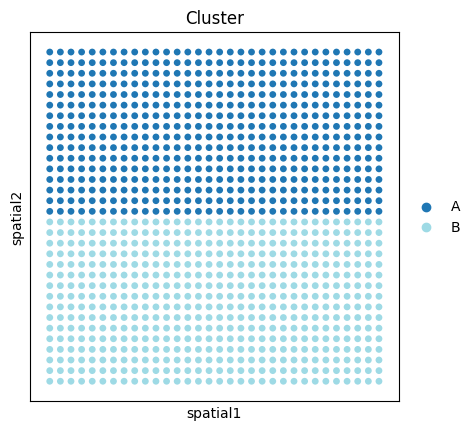

In [13]:
import numpy as np
import matplotlib.pyplot as plt
np.unique (adata.obs['group'])
sc.pl.spatial(adata, color="group",palette='tab20', title='Cluster', spot_size=0.02,show=False) 
plt.savefig("figures/synthetic_data_groups.png", dpi=300, bbox_inches="tight")

In [14]:
rng = np.random.default_rng(seed=43)
adata.obs['group_perm'] = rng.permutation(adata.obs['group'].values)

Silhouette Spatial Score (SSS): -0.3913
SSS average penalty: 0.6509
silhouette:  -1e-04


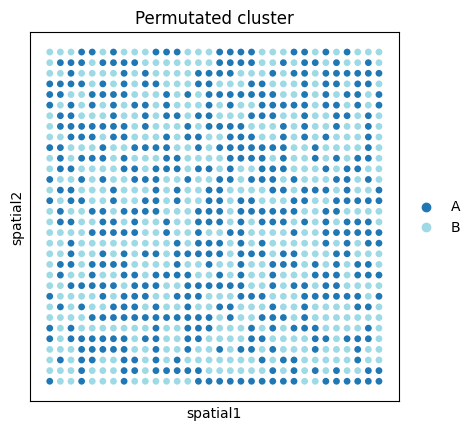

In [15]:

    # Run SSS computation
silhouette_spatial = silhouette_spatial_score(
        adata.obsm["X_pca"],
        adata.obs['group_perm'],
        adata,
        metric="cosine",
        is_visium=False
    )
adata.uns["SSS"] = silhouette_spatial

print("Silhouette Spatial Score (SSS):", np.round(silhouette_spatial, 4))

if "average_penalty" in adata.uns:
        penalty = adata.uns["average_penalty"]
        print("SSS average penalty:", np.round(penalty, 4))
else:
        print("Warning: average_penalty not found in `adata.uns`.")

silhouette = silhouette_score(adata.obsm["X_pca"], adata.obs['group_perm'], metric='cosine') 
print("silhouette: ",np.round(silhouette,4))
sc.pl.spatial(adata, color="group_perm",palette='tab20', title='Permutated cluster', spot_size=0.02,show=False) 
plt.savefig("figures/synthetic_data_groups_perm.png", dpi=300, bbox_inches="tight")

In [16]:
import numpy as np

n = adata.obsm['spatial'].shape[0]
rng = np.random.default_rng(seed=43)
perm = rng.choice(n, size=n, replace=False)
adata.obsm['spatial'] = adata.obsm['spatial'][perm]



Silhouette Spatial Score (SSS): 0.5887
SSS average penalty: 0.7061
silhouette:  0.7535

Silhouette Spatial Score (SSS): 0.5673
SSS average penalty: 0.7444
silhouette:  0.7535


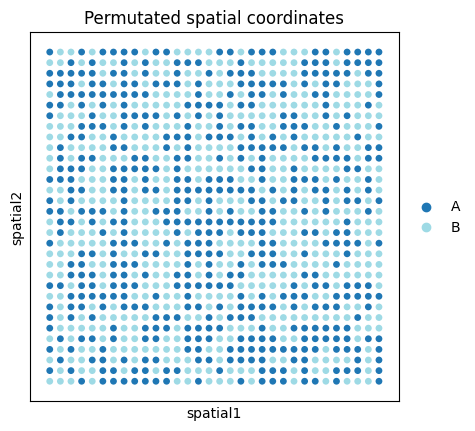

In [17]:

    # Run SSS computation
silhouette_spatial = silhouette_spatial_score(
        adata.obsm["X_pca"],
        adata.obs['group'],
        adata,
        metric="cosine",
        is_visium=False, 
      
    )
adata.uns["SSS"] = silhouette_spatial

print("Silhouette Spatial Score (SSS):", np.round(silhouette_spatial, 4))

if "average_penalty" in adata.uns:
        penalty = adata.uns["average_penalty"]
        print("SSS average penalty:", np.round(penalty, 4))
else:
        print("Warning: average_penalty not found in `adata.uns`.")

silhouette = silhouette_score(adata.obsm["X_pca"], adata.obs['group'], metric='cosine') 
print("silhouette: ",np.round(silhouette,4))
sc.pl.spatial(adata, color="group",palette='tab20', title='Permutated spatial coordinates', spot_size=0.02,show=False) 
plt.savefig("figures/synthetic_data_spatial_perm.png", dpi=300, bbox_inches="tight")